## installing packages and libraries

In [1]:
# Importing the libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# text preprocessing of reviews
# libraries for text preprocessing
import re
import string
from bs4 import BeautifulSoup
!pip install contractions
import contractions
from contractions import fix
!pip install emoji
import emoji
!pip install pyspellchecker
from spellchecker import SpellChecker
spell = SpellChecker()
# tokenization
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
# Stop word removal
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('words')
words_eng = set(nltk.corpus.words.words())


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Dropout,BatchNormalization

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss

import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Defining functions

In [2]:
# Converting test to tolowercase, remove punctuation, numbers, special characters, and HTML tags, expanding contractions, handling emojis and spell correction
def clean_text(text):
    text = text.lower()  # Lowercase
    # Replace certain special characters
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    text = text.replace('[math]', '')

    # Replacing some numbers with string eqivalents (not perfect, can be done better to account for more cases)
    text = text.replace(',000,000,000', 'b ')
    text = text.replace(',000,000', 'm ')
    text = text.replace(',000', 'k ')
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)

    # text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove non word and non white space characters
    text = " ".join([contractions.fix(doc) for doc in text.split()]) # expanding text contractions
    text = " ".join([emoji.demojize(doc) for doc in text.split()]) # handling emojis
    # text = " ".join([spell.correction(doc) for doc in text.split()]) # spell corrections
    # # stop word removal
    text=' '.join(word for word in text.split() if word not in stop_words)
    # removing non english words
    text = " ".join(w for w in text.split() if w in words_eng or not w.isalpha())
    return text

In [3]:
# Confusion metrics for predictions
def conf_matrix(cf_matrix):
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## Data upload and Text Preprocessing

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Career/AI/DL Projects/IMDB Reviews Sentiment Analysis/IMDB Dataset.csv')

In [ ]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
df.sentiment.value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
df['sentiment']=df['sentiment'].apply(lambda x : 1 if x=='positive' else 0)
df.sentiment.value_counts()

,count
sentiment,
1,25000
0,25000


In [ ]:
# text preprocessing
df['review']=df['review'].apply(clean_text)

In [ ]:
pd.set_option('display.max_colwidth', None)
df.head(5)

,review,sentiment
0,one watching 1 episode hooked right exactly first thing struck brutality unflinching violence set right word go trust show faint hearted timid show sex violence classic use nickname given maximum security state mainly emerald city experimental section prison glass face inwards privacy high agenda city home death dodgy shady never far would say main appeal show due fact goes would dare forget pretty painted forget charm forget mess around first episode ever saw struck nasty could say ready watched taste got accustomed high graphic violence violence injustice crooked sold nickel kill order get away well mannered middle class turned prison due lack street prison experience watching may become comfortable uncomfortable get touch side,1
1,wonderful little production technique unassuming fashion comforting sometimes discomforting sense realism entire piece extremely well chosen sheen got pat truly see seamless diary well worth watching terrificly written piece masterful production one great comedy life realism really comes home little fantasy guard rather use traditional dream remains solid knowledge particularly concerning particularly flat every surface terribly well done,1
2,thought wonderful way spend time hot summer weekend sitting air conditioned theater watching lighthearted comedy plot simplistic dialogue witty likable even well bread suspected serial killer may disappointed realize match point 2 risk addiction thought proof woody still fully control style many us grown id one dare say decade never scarlet tone sexy image right average spirited young may crown jewel career devil interesting superman great comedy go see,1
3,basically family little boy jake zombie closet fighting movie soap opera suddenly jake become kill first going make film must decide thriller drama drama movie watchable like real life jake closet totally film see similar movie instead watched drama meaningless thriller 3 10 well descent jake ignore,0
4,petter love time money visually stunning film watch us vivid portrait human movie telling us money power success people different encounter variation play theme director action present time new york different meet connect one connected one way another next person one know previous point contact stylishly film sophisticated luxurious look taken see people live world live thing one picture different loneliness one big city exactly best place human find sincere fulfillment one case people acting good direction rosario carol rest talented cast make come wish good luck await anxiously next work,1


In [ ]:
pd.set_option('display.max_colwidth', 50)
df.head(5)

,review,sentiment
0,one watching 1 episode hooked right exactly fi...,1
1,wonderful little production technique unassumi...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake zombie closet...,0
4,petter love time money visually stunning film ...,1


In [ ]:
# Storing the processed dataframe for further use
pickle_path = '/content/drive/MyDrive/Career/AI/DL Projects/IMDB Reviews Sentiment Analysis/'
pickle_out=open(pickle_path+'df.pickle', 'wb')
pickle.dump(df,pickle_out)
pickle_out.close()

In [4]:
# Importing the final featurized dataframe
pickle_in=open("/content/drive/MyDrive/Career/AI/DL Projects/IMDB Reviews Sentiment Analysis/df.pickle","rb")
df=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized df_final dataframe is",df.shape)

Shape of featurized df_final dataframe is (50000, 2)


## Train test split

In [5]:
# Lets build the model considering first 20,000 rows. Train test split will happen on these 20000 rows. Rest 30000 will be used as OOT
df_train_test=df.iloc[:20000]
df_oot=df.iloc[20000:]
print(df_train_test.shape)
print(df_oot.shape)
df_train_test.sentiment.value_counts()

(20000, 2)
(30000, 2)


,count
sentiment,
0,10097
1,9903


In [6]:
# lets train test split the data
x_train, x_test, y_train, y_test = train_test_split(df_train_test['review'], df_train_test['sentiment'], test_size=0.1, random_state=42)

In [7]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (18000,)
y_train shape: (18000,)
x_test shape: (2000,)
y_test shape: (2000,)


In [8]:
x_train

,review
16270,remember lyricist brother film snapped many ty...
1383,caught farewell king cable maybe girl thought ...
3472,like anybody make movie nowadays like need cam...
19900,concept behind horror something going horror l...
2150,usually write comment many time feel spoken ta...
...,...
11284,shadow magic joy amazement first movie also po...
11964,taken premise film good one good film require ...
5390,cannot knock film terribly obvious midway watc...
860,production quite surprise absolutely love obsc...


## Tokenization research
Refer simple RNN ipython file for the mode details about selecting
1. Select the correct representation method
2. select the suitable vocab size
3. select the suitable sentence length

## Word embedding

In [9]:
# keras tokenizer on test string
max_features=1000
tokenize  = Tokenizer(num_words=max_features,oov_token='<oov>')
tokenize.fit_on_texts(x_train)

In [10]:
x_train_features=tokenize.texts_to_sequences(x_train)
x_test_features=tokenize.texts_to_sequences(x_test)
print(x_train_features[0])
print(x_test_features[0])

[241, 1, 442, 3, 1, 26, 510, 1, 2, 465, 1, 1, 344, 65, 206, 1, 131, 517, 1, 465, 469, 517, 579, 1, 987, 131, 4, 30, 664, 2, 465, 4, 311, 584, 733, 39, 541, 25, 220, 74, 483, 1, 1, 1, 1, 9, 492, 305, 3, 707, 1, 8, 1, 707, 1, 13, 1, 1, 1, 93, 1, 9, 1, 371, 707, 1, 29, 51, 631, 68, 238, 255, 8, 32, 75, 417, 1, 14, 41, 1, 1, 55, 1, 41, 74, 1, 331, 1, 31, 14, 1, 8, 47, 1, 105, 59, 74, 90, 1, 1, 1, 1, 1, 465, 73, 1, 43, 693, 1, 1, 19, 128, 31, 1, 120, 1, 3, 331, 1, 1, 45, 3, 298, 256, 98, 18, 1, 128, 585, 135, 1, 1, 25, 465, 13, 153, 109, 1, 98, 13, 304, 494, 1, 264, 1, 279, 6, 1, 1]
[70, 1, 147, 294, 166, 4, 34, 106, 39, 18, 611, 287, 143, 6, 163, 868, 609, 106, 6, 1, 1, 811, 1, 677, 486, 44, 6, 1, 1, 295, 759, 31, 6, 611, 1, 1, 659, 125, 373, 28, 87, 466, 375, 75, 435, 467, 636, 1, 638, 347, 201, 1, 28, 50, 601, 435, 37]


In [11]:
print(len([max(i) for i in x_train_features]))
print(max([max(i) for i in x_train_features])+1) # vocab size

18000
1000


In [12]:
sent_length=120
x_train_embedded_docs=pad_sequences(x_train_features,padding='pre',maxlen=sent_length)
x_test_embedded_docs=pad_sequences(x_test_features,padding='pre',maxlen=sent_length)

In [13]:
print(x_train_embedded_docs[0])
print(x_test_embedded_docs[0])

[  2 465   4 311 584 733  39 541  25 220  74 483   1   1   1   1   9 492
 305   3 707   1   8   1 707   1  13   1   1   1  93   1   9   1 371 707
   1  29  51 631  68 238 255   8  32  75 417   1  14  41   1   1  55   1
  41  74   1 331   1  31  14   1   8  47   1 105  59  74  90   1   1   1
   1   1 465  73   1  43 693   1   1  19 128  31   1 120   1   3 331   1
   1  45   3 298 256  98  18   1 128 585 135   1   1  25 465  13 153 109
   1  98  13 304 494   1 264   1 279   6   1   1]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  70   1 147 294 166   4  34 106  39
  18 611 287 143   6 163 868 609 106   6   1   1 811   1 677 486  44   6
   1   1 295 759  31   6 611   1   1 659 125 373  28  87 466 375  75 435
 467 636   1 638 347 201   1  28  50 601 435  37]


In [14]:
# verification for padding
print(len(x_train_features))
print(len(x_train_features[0]))
print(len(x_test_features[0]))
print(x_train_features[0][149-120:149-115]) # this is limited to sentence length

18000
149
57
[2, 465, 4, 311, 584]


## Deep RNN Model

In [15]:
# early stopping callback
earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
earlystopping

In [16]:
# simple RNN model
model=Sequential()
model.add(Embedding(input_dim=max_features,output_dim=128,input_length=sent_length))
model.add(SimpleRNN(64, return_sequences=True,activation='relu',kernel_initializer='he_uniform'))
model.add(SimpleRNN(64,activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid',kernel_initializer='glorot_uniform'))
model.build(input_shape=(None, sent_length))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 128)            │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 120, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,673 (580.75 KB)

 Trainable params: 148,673 (580.75 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history=model.fit(x_train_embedded_docs, y_train, epochs=30, batch_size=32, validation_split=0.2,callbacks=earlystopping)

Epoch 1/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.6058 - loss: 0.6311 - val_accuracy: 0.7703 - val_loss: 0.4818
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.8179 - loss: 0.4168 - val_accuracy: 0.8342 - val_loss: 0.4024
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8612 - loss: 0.3355 - val_accuracy: 0.8286 - val_loss: 0.4116
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.8637 - loss: 0.3331 - val_accuracy: 0.8325 - val_loss: 0.3907
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.8855 - loss: 0.2834 - val_accuracy: 0.8328 - val_loss: 0.3935
Epoch 6/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.8896 - loss: 0.2652 - val_accuracy: 0.6553 - val_loss: 0.6941
Epoch 7/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.8244 - loss: 0.3907 - val_accuracy: 0.7947 - val_loss: 0.4463
Epoch 8/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.9078 - loss: 0.2287 - 

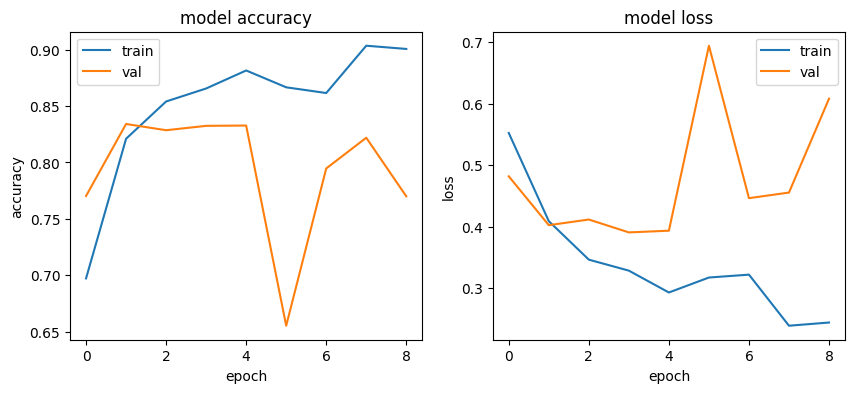

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [21]:
# save model file
model.save('/content/drive/MyDrive/Career/AI/DL Projects/IMDB Reviews Sentiment Analysis/deep_rnn.h5')

In [22]:
model = load_model('/content/drive/MyDrive/Career/AI/DL Projects/IMDB Reviews Sentiment Analysis/deep_rnn.h5')

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 128)            │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 120, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,675 (580.77 KB)

 Trainable params: 148,673 (580.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Model Predictions on train and test

In [24]:
# model predictions on test features and its comparison
predict_proba_train=model.predict(x_train_embedded_docs)
predict_proba_test=model.predict(x_test_embedded_docs)
predictions_train = (predict_proba_train > 0.5).astype("int32")
predictions_test = (predict_proba_test > 0.5).astype("int32")

563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


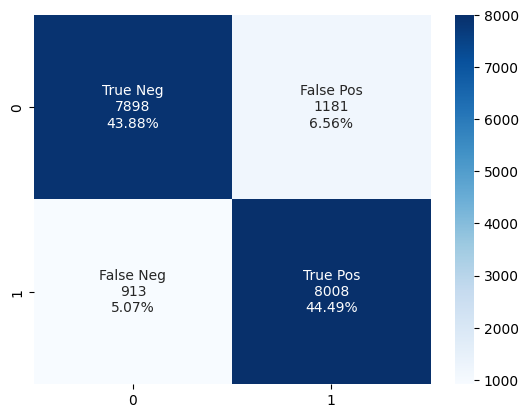

In [26]:
# trian confusion matrix
cf_matrix = confusion_matrix(y_train, predictions_train)
conf_matrix(cf_matrix)

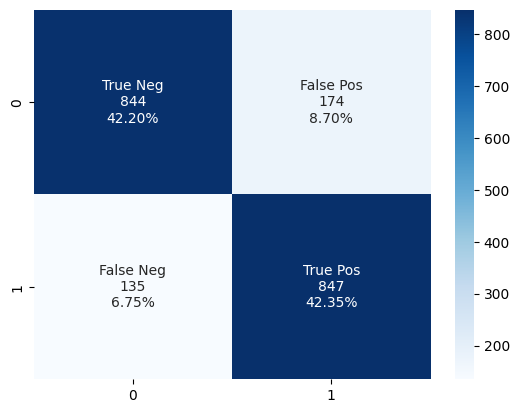

In [27]:
# test confusion matrix
cf_matrix = confusion_matrix(y_test, predictions_test)
conf_matrix(cf_matrix)

In [28]:
print('Train accuracy is {}% while test accuracy is {}%.'.format(round(accuracy_score(y_train, predictions_train),4)*100,round(accuracy_score(y_test, predictions_test),2)*100))
print('Train log loss is {} while test log loss is {}.'.format(log_loss(y_train,predict_proba_train),log_loss(y_test,predict_proba_test)))

Train accuracy is 88.37% while test accuracy is 85.0%.
Train log loss is 0.28820620019250015 while test log loss is 0.35193475124438806.


## Model prediction on oot data

In [29]:
df_oot.head(5)

,review,sentiment
20000,huge fan northern exposure men complete knocko...,0
20001,watched movie let go thought could acting writ...,0
20002,story hare hare actually came dev mind saw fal...,1
20003,oddly enough screwy part screwball comedy lomb...,0
20004,horror comedy like one might get quickly shut ...,0


In [30]:
x_oot=df['review']
y_oot=df['sentiment']

In [31]:
x_oot_features=tokenize.texts_to_sequences(x_oot)
print(x_oot_features[0])

[4, 52, 330, 261, 1, 91, 394, 21, 54, 1, 1, 1, 377, 153, 91, 441, 48, 1, 37, 1, 1, 1, 37, 244, 377, 210, 191, 1, 202, 1, 1, 848, 1, 1, 350, 1, 1, 880, 1, 248, 1, 1, 190, 1, 350, 196, 204, 1, 1, 29, 116, 7, 44, 149, 929, 37, 449, 83, 146, 7, 1, 565, 71, 1, 565, 1, 565, 666, 78, 21, 261, 39, 94, 1, 1, 16, 44, 1, 158, 885, 73, 1, 190, 1, 377, 377, 1, 1, 1, 1, 329, 421, 15, 121, 13, 1, 536, 599, 447, 880, 449, 359, 668, 880, 369, 52, 84, 258, 1, 1, 15, 852, 328]


In [32]:
x_oot_embedded_docs=pad_sequences(x_oot_features,padding='pre',maxlen=sent_length)

In [33]:
print(x_oot_embedded_docs[0])
print(x_oot_embedded_docs[1])

[  0   0   0   0   0   0   0   4  52 330 261   1  91 394  21  54   1   1
   1 377 153  91 441  48   1  37   1   1   1  37 244 377 210 191   1 202
   1   1 848   1   1 350   1   1 880   1 248   1   1 190   1 350 196 204
   1   1  29 116   7  44 149 929  37 449  83 146   7   1 565  71   1 565
   1 565 666  78  21 261  39  94   1   1  16  44   1 158 885  73   1 190
   1 377 377   1   1   1   1 329 421  15 121  13   1 536 599 447 880 449
 359 668 880 369  52  84 258   1   1  15 852 328]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 235  32 219   1   1   1   1 325   1 163
   1 267 259 349  13   1   1  73   1 215  11   1   1  13 144  52   1 282
 259   1 219   4  18  99  40   1  10 138 196  32 817   1 120 191   1 768
 866 818   1 368   1 368 788  66   1   1  13 100]


In [34]:
# model predictions
predict_proba_oot=model.predict(x_oot_embedded_docs)
predictions_oot = (predict_proba_oot > 0.5).astype("int32")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step


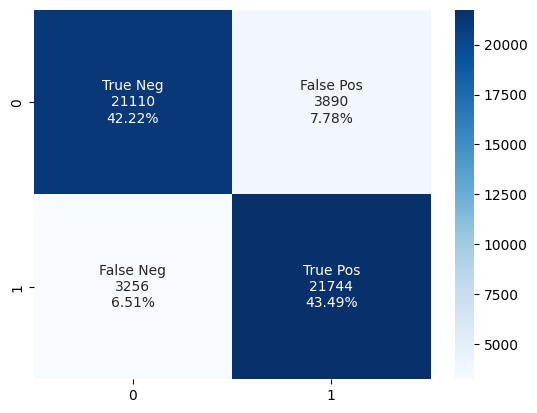

In [35]:
# trian confusion matrix
cf_matrix = confusion_matrix(y_oot, predictions_oot)
conf_matrix(cf_matrix)

In [36]:
print('Train accuracy is {}%, test accuracy is {}% and oot accuracy is {}%.'.format(round(accuracy_score(y_train, predictions_train),4)*100,round(accuracy_score(y_test, predictions_test),2)*100,round(accuracy_score(y_oot, predictions_oot),4)*100))
print('Train log loss is {}, test log loss is {} and oot log loss is {}.'.format(log_loss(y_train,predict_proba_train),log_loss(y_test,predict_proba_test),log_loss(y_oot,predict_proba_oot)))

Train accuracy is 88.37%, test accuracy is 85.0% and oot accuracy is 85.71%.
Train log loss is 0.28820620019250015, test log loss is 0.35193475124438806 and oot log loss is 0.3360177137297739.
